In [2]:
# Core packages
import numpy as np                           
import pandas as pd                          
import re 
import matplotlib.pyplot as plt              
import seaborn as sns                        
# Data preprocessing and selection
from collections import Counter
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import string
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize

# Misc
import warnings                                                  
warnings.filterwarnings('ignore')                                 
pd.set_option('display.max_columns', 100)                       

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Data Cleaning and Preprocessing


## 1.1 Load Raw Datasets


In [3]:
# Read raw datasets
df1 = pd.read_csv('../data/raw/emails.csv')
df2 = pd.read_csv('../data/raw/spam.csv')
df3 = pd.read_csv('../data/raw/spam_ham_dataset.csv')
df4 = pd.read_csv('../data/raw/completeSpamAssassin.csv')

In [4]:
# Display the first few rows of the dataset
df1.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [5]:
df2.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df3.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [7]:
df4.head()

,Unnamed: 0,Body,Label
0,0,\nSave up to 70% on Life Insurance.\nWhy Spend...,1
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
2,2,1) Fight The Risk of Cancer!\nhttp://www.adcli...,1
3,3,##############################################...,1
4,4,I thought you might like these:\n1) Slim Down ...,1


## 1.2 Data Merging


In [ ]:
# Normalize datasets
# df1
df1 = df1[['text', 'spam']]
print("df1:", len(df1))

# df2
# Remove BOM and whitespace from column names
df2.columns = df2.columns.str.replace('\ufeff', '').str.strip()
df2 = df2[['Category', 'Message']].copy()
df2.rename(columns={'Message': 'text'}, inplace=True)
df2['spam'] = df2['Category'].map({'ham': 0, 'spam': 1})
df2 = df2[['text', 'spam']]
print("df2:", len(df2))

# df3
df3 = df3[['text', 'label_num']].copy()
df3.rename(columns={'label_num': 'spam'}, inplace=True) # 0: ham, 1: spam
print("df3:", len(df3))

# df4
df4 = df4[['Body', 'Label']].copy()
df4.rename(columns={'Label': 'spam', 'Body': 'text'}, inplace=True)
df4 = df4[['text', 'spam']]
print("df4:", len(df4))


# Merge all normalized datasets into a single dataset
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
print("Merge all nomalized datasets into a single dataset", len(pd.concat([df1, df2, df3, df4])))

# Save the merged dataset
df.to_csv('../data/processed/Merged_datasets.csv', index=False)
print(f"Done. Rows: {len(df)}")

df1: 5728
df2: 5572
df3: 5171
df4: 6046
Merge all nomalized datasets into a single dataset 22517
Done. Rows: 22517


## 1.3 Data Cleaning


In [9]:
#Load the data and preview it
df = pd.read_csv("../data/processed/Merged_datasets.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [10]:
#rows and columns 
print(f"Shape of the dataset: {df.shape}") #rows, columns

df.head()

Shape of the dataset: (22517, 2)


,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


In [11]:
#Data types and non-null counts for each column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22517 entries, 0 to 22516
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    22516 non-null  object
 1   spam    22517 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 352.0+ KB


In [ ]:
#Statistical summary of numerical columns
df.describe()

,spam
count,22517.000000
mean,0.244704
std,0.429921
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [ ]:
# Check for missing values
df.drop_duplicates(inplace=True) # Remove duplicates

df.dropna(subset=['text', 'spam'], inplace=True) # Remove rows with missing values in 'text' or 'spam' columns
df = df[df['text'].str.strip() != ""] # Remove empty text entries

df['spam'] = df['spam'].astype(int) # Ensure 'spam' column is of integer type

print(df.info()) # Check data info after cleaning
print(df.head(10)) # Preview the cleaned data

<class 'pandas.core.frame.DataFrame'>
Index: 21137 entries, 0 to 22514
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21137 non-null  object
 1   spam    21137 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 495.4+ KB
None
                                                text  spam
0  Subject: naturally irresistible your corporate...     1
1  Subject: the stock trading gunslinger  fanny i...     1
2  Subject: unbelievable new homes made easy  im ...     1
3  Subject: 4 color printing special  request add...     1
4  Subject: do not have money , get software cds ...     1
5  Subject: great nnews  hello , welcome to medzo...     1
6  Subject: here ' s a hot play in motion  homela...     1
7  Subject: save your money buy getting this thin...     1
8  Subject: undeliverable : home based business f...     1
9  Subject: save your money buy getting this thin...     1


In [ ]:
print(df['spam'].value_counts())     # Count of each class in 'spam' column
print(df.duplicated().sum())         # Count of duplicate rows
print(df.isnull().sum())             # Count of missing values in each column

spam
0    16289
1     4848
Name: count, dtype: int64
0
text    0
spam    0
dtype: int64


In [ ]:
df.to_csv("../data/processed/Cleaned_dataset.csv", index=False) # Save the cleaned dataset
print("Already saved the cleaned dataset")

Already saved the cleaned dataset


## 1.4 EDA Exploration

spam
0    16289
1     4848
Name: count, dtype: int64
spam
0    77.063916
1    22.936084
Name: count, dtype: float64


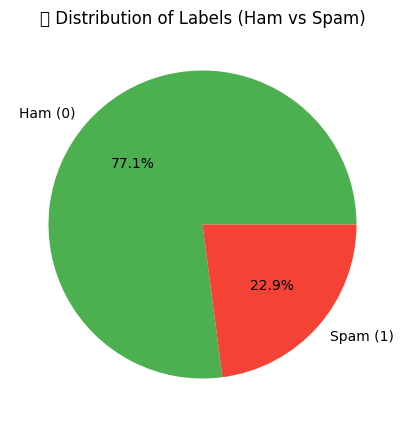

In [ ]:
# Visualize the distribution of labels
df = pd.read_csv("../data/processed/Cleaned_dataset.csv")

# Count the number of samples in each class
label_counts = df['spam'].value_counts()
print(label_counts)
print(label_counts / len(df) * 100)
# Pie chart for label distribution
plt.figure(figsize=(5,5))
label_counts.plot(kind='pie', labels=['Ham (0)', 'Spam (1)'], autopct='%1.1f%%', colors=['#4CAF50', '#F44336'])
plt.title("📊 Distribution of Labels (Ham vs Spam)")
plt.ylabel("")
plt.show()

                                                text  spam  \
0  Subject: naturally irresistible your corporate...     1   
1  Subject: the stock trading gunslinger  fanny i...     1   

                                      transform_text  Length  num_words  \
0  subject naturally irresistible corporate ident...    1484        325   
1  subject stock trading gunslinger fanny merrill...     598         90   

   num_sentence  
0            11  
1             1  
Average Length of Spam Emails: 1445.434199669967
Average Length of Ham Emails: 1100.2894591442077


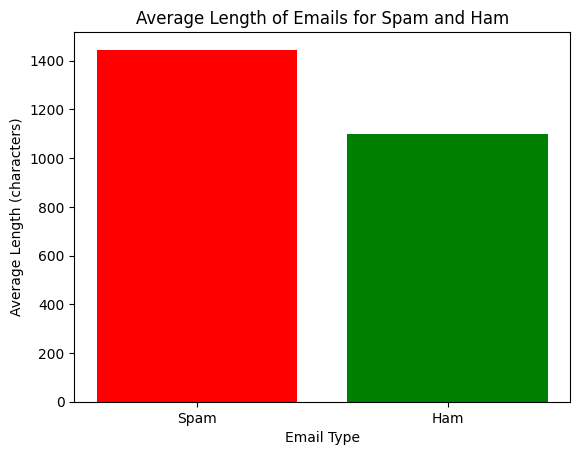

In [ ]:
# Feature Engineering: Text Length, Word Count, Sentence Count
df['text'] = df['text'].fillna("").astype(str)

df['Length'] = df['text'].apply(len)                      
df['num_words'] = df['text'].apply(lambda x: len(word_tokenize(x)))  
df['num_sentence'] = df['text'].apply(lambda x: len(sent_tokenize(x))) 

print(df.head(2))

avg_length_spam = df[df['spam'] == 1]['Length'].mean()
avg_length_ham = df[df['spam'] == 0]['Length'].mean()

print("Average Length of Spam Emails:", avg_length_spam)
print("Average Length of Ham Emails:", avg_length_ham) 

# Plotting
plt.bar(['Spam', 'Ham'], [avg_length_spam, avg_length_ham], color=['red', 'green'])
plt.title('Average Length of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Length (characters)')
plt.show()

Average Words of Spam Emails: 273.8591171617162
Average Words of Ham Emails: 228.84474185032843


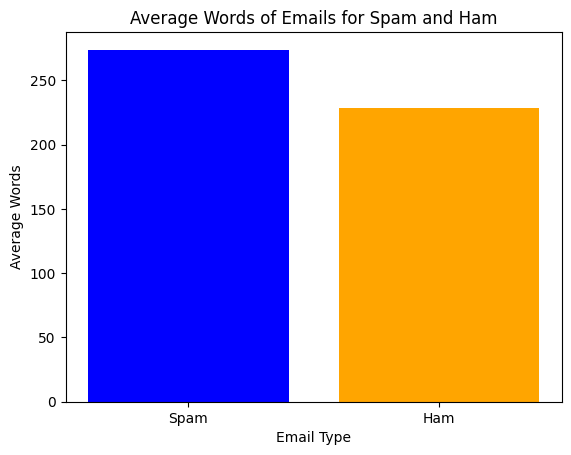

In [ ]:
# Word Count
avg_word_spam = df[df['spam'] == 1]['num_words'].mean()
avg_word_ham = df[df['spam'] == 0]['num_words'].mean()
print("Average Words of Spam Emails:", avg_word_spam)
print("Average Words of Ham Emails:", avg_word_ham)
# Plotting
plt.bar(['Spam', 'Ham'], [avg_word_spam, avg_word_ham], color=['Blue', 'orange'])
plt.title('Average Words of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Words')
plt.show()

Average Sentence of Spam Emails: 15.463696369636963
Average Sentence of Ham Emails: 11.055006446067898


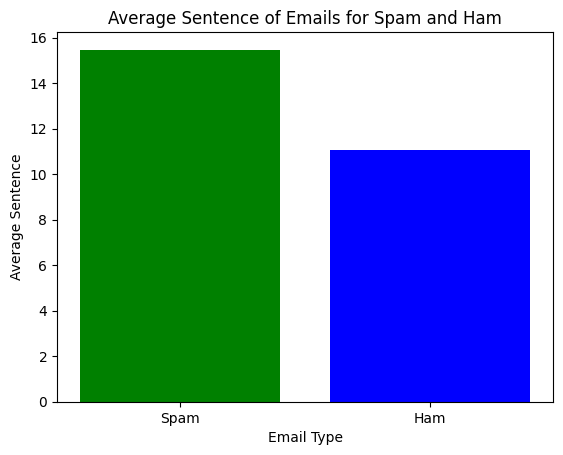

In [ ]:
# Sentence Count
avg_sentence_spam = df[df['spam'] == 1]['num_sentence'].mean()
avg_sentence_ham = df[df['spam'] == 0]['num_sentence'].mean()
print("Average Sentence of Spam Emails:", avg_sentence_spam)
print("Average Sentence of Ham Emails:", avg_sentence_ham)

# Plotting
plt.bar(['Spam', 'Ham'], [avg_sentence_spam, avg_sentence_ham], color=['Green', 'Blue'])
plt.title('Average Sentence of Emails for Spam and Ham')
plt.xlabel('Email Type')
plt.ylabel('Average Sentence')
plt.show()

In [ ]:
# Analyze spam rate by text length bins
bins = [0, 50, 100, 150, 200, 300, 500, 1000]
df['length_bin'] = pd.cut(df['Length'], bins=bins)
spam_rate_by_len = df.groupby('length_bin')['spam'].mean()
print(spam_rate_by_len)

length_bin
(0, 50]        0.037363
(50, 100]      0.097308
(100, 150]     0.247598
(150, 200]     0.389041
(200, 300]     0.243439
(300, 500]     0.302315
(500, 1000]    0.295106
Name: spam, dtype: float64


## 1.4 Data Preproccessing


In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet'); nltk.download('omw-1.4')

# Text Preprocessing and Lemmatization
df = pd.read_csv("../data/processed/Cleaned_dataset.csv")
df['spam'] = df['spam'].astype(int)

base_stop = set(stopwords.words('english'))
promo_keep = {
    'free','win','prize','price','cash','money','claim','offer','click',
    'urgent','now','call','text','reward','bonus','gift','credit','loan',
    'deal','sale','discount','limited'
}
stop_light = base_stop - promo_keep

# POS mapping for lemmatizer
def _to_wn_pos(tag):
    if tag.startswith('J'): return wordnet.ADJ
    if tag.startswith('V'): return wordnet.VERB
    if tag.startswith('N'): return wordnet.NOUN
    if tag.startswith('R'): return wordnet.ADV
    return wordnet.NOUN 

lemm = WordNetLemmatizer()

def preprocess_lemmatize(s: str) -> str:
    s = str(s).lower()
    # remove urls/emails/phones/numbers/tokens-with-digits
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    s = re.sub(r'\b\S+@\S+\.\S+\b', ' ', s)
    s = re.sub(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', s)
    s = re.sub(r'\b\d{5,}\b', ' ', s)
    s = re.sub(r'\b[a-z]*\d+[a-z]*\b', ' ', s)
    # drop common leftovers if any
    s = re.sub(r'\b(?:http|https|www|com|escape\w*)\b', ' ', s)
    # keep letters + spaces, compress spaces
    s = re.sub(r'[^a-z\s]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()

    # tokenize + POS tag
    toks = word_tokenize(s)
    toks = [w for w in toks if len(w) > 1 and w not in stop_light]
    if not toks: return ""

    tagged = pos_tag(toks)
    lemmas = [lemm.lemmatize(w, _to_wn_pos(t)) for w, t in tagged]
    return " ".join(lemmas)

# Apply preprocessing and lemmatization
df['transform_text'] = df['text'].apply(preprocess_lemmatize)
# Save the preprocessed dataset
df[['text','transform_text','spam']].to_csv("../data/processed/Preprocessed_dataset.csv", index=False)
print("Saved: data/processed/Preprocessed_dataset.csv | rows:", len(df))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Saved: data/processed/Preprocessed_dataset.csv | rows: 21137


## 1.5 Common Words in Spam and Ham Emails

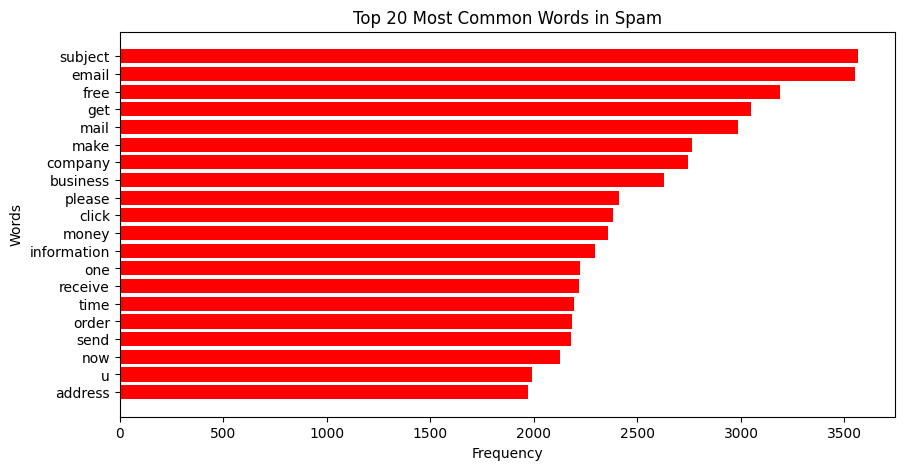

In [ ]:
# Word Frequency Analysis in Spam Emails
spam_words = " ".join(df[df['spam'] == 1]['transform_text']).split()
spam_freq = Counter(spam_words).most_common(20)
# Plotting
words, counts = zip(*spam_freq)
plt.figure(figsize=(10,5))
plt.barh(words[::-1], counts[::-1], color='red')
plt.title("Top 20 Most Common Words in Spam")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()

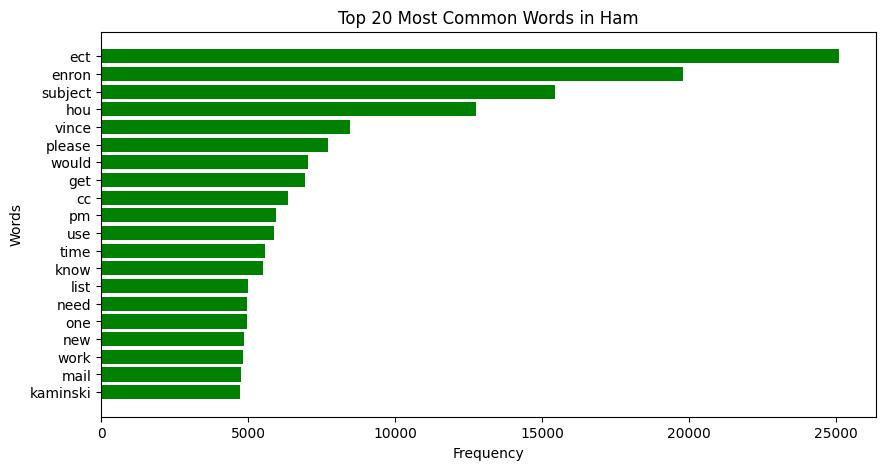

In [ ]:
# Word Frequency Analysis in Ham Emails
ham_words = " ".join(df[df['spam'] == 0]['transform_text']).split()
ham_freq = Counter(ham_words).most_common(20)

# Plotting
words, counts = zip(*ham_freq)
plt.figure(figsize=(10,5))
plt.barh(words[::-1], counts[::-1], color='green')
plt.title("Top 20 Most Common Words in Ham")
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()